<a href="https://colab.research.google.com/github/jack-baxter/AAI521-G6-Final/blob/main/Group_6_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><center>AAI-521 Final Project
<br><center>Solar Panel Defect Detection
<br><center>Group 6
<br><center>Fall 2025, Dr. Albuyeh
<br><center>Jamshed Nabizada, Jack Baxter, Naima Botros


Install dependencies


In [ ]:
# Install necessary deep learning and utility libraries
!pip install torch torchvision torchaudio pandas numpy scikit-learn matplotlib seaborn Pillow


Imports & Google Drive Mount

In [2]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc



# Mount Google Drive
drive.mount('/content/drive')

print("Environment setup complete. Drive mounted.")


Mounted at /content/drive
Environment setup complete. Drive mounted.


In [ ]:
!ls /content/drive/MyDrive/aai_521

 aai_521_p
 Discussion
'Learning OpenCV 4 Computer Vision with Python 3.pdf'
 module_4
 module_5
'Practical machine learning for computer vision.pdf'


Dataset Path Configuration

In [3]:
# Base directory for the Kaggle ELPV folder structure
# (train/ test/ valid/ folders already exist)
BASE_DIR = '/content/drive/MyDrive/ELPV_SOLAR_DATA/'

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError("BASE_DIR does not exist. Check your Google Drive path.")

print("BASE_DIR:", BASE_DIR)


BASE_DIR: /content/drive/MyDrive/ELPV_SOLAR_DATA/


Load and Convert Label Files → Binary Classification

In [4]:
def create_binary_classification_labels(root_dir):
    """
    Scans train/test/valid folders and creates a dataframe:
    - image_path
    - label (0 = no defect, 1 = defect)

    A .txt label file with content indicates a defect.
    Empty or missing file = non-defective.
    """
    data_list = []

    for split_dir in ["train", "test", "valid"]:
        img_dir = os.path.join(root_dir, split_dir, "images")
        lbl_dir = os.path.join(root_dir, split_dir, "labels")

        if not os.path.isdir(img_dir):
            continue

        for img_name in os.listdir(img_dir):
            name, ext = os.path.splitext(img_name)
            if ext.lower() not in [".png", ".jpg", ".jpeg"]:
                continue

            img_path = os.path.join(img_dir, img_name)
            txt_path = os.path.join(lbl_dir, name + ".txt")

            # Binary label logic
            label = 1 if (os.path.exists(txt_path) and os.path.getsize(txt_path) > 0) else 0

            data_list.append({
                "image_path": img_path,
                "label": label
            })

    return pd.DataFrame(data_list)


df_full = create_binary_classification_labels(BASE_DIR)

if df_full.empty:
    raise SystemExit("ERROR: No images found. Check BASE_DIR path.")

print("Total images found:", len(df_full))
print(df_full.head())
print("\nClass distribution:\n", df_full["label"].value_counts())


Total images found: 7435
                                          image_path  label
0  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
1  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
2  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
3  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
4  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1

Class distribution:
 label
1    7332
0     103
Name: count, dtype: int64


Stratified Train/Val/Test Split (80/10/10)

In [5]:
df_train, df_temp = train_test_split(
    df_full, test_size=0.20, stratify=df_full["label"], random_state=42
)

df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp["label"], random_state=42
)

print("\nFinal Split Sizes:")
print("Train:", len(df_train))
print("Val:  ", len(df_val))
print("Test: ", len(df_test))



Final Split Sizes:
Train: 5948
Val:   743
Test:  744


EDA: Class Distribution Visualization

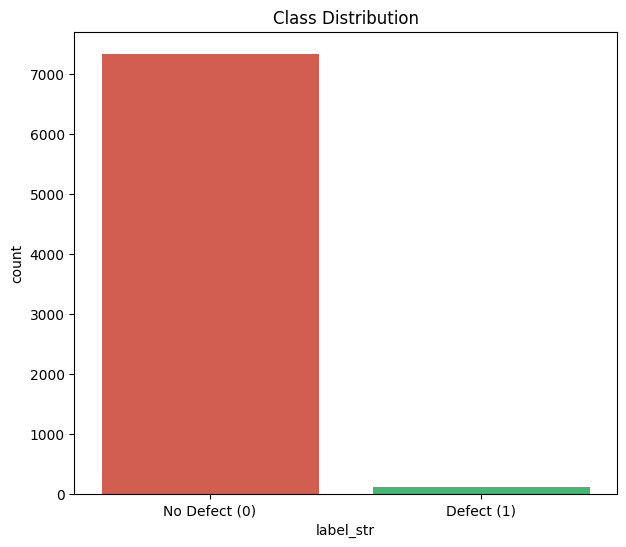

In [6]:
df_full["label_str"] = df_full["label"].astype(str)

plt.figure(figsize=(7,6))
sns.countplot(
    x="label_str",
    hue="label_str",
    data=df_full,
    palette={"0": "#2ecc71", "1": "#e74c3c"}
)
plt.xticks([0, 1], ["No Defect (0)", "Defect (1)"])
plt.title("Class Distribution")
plt.show()


Visual Sample Check

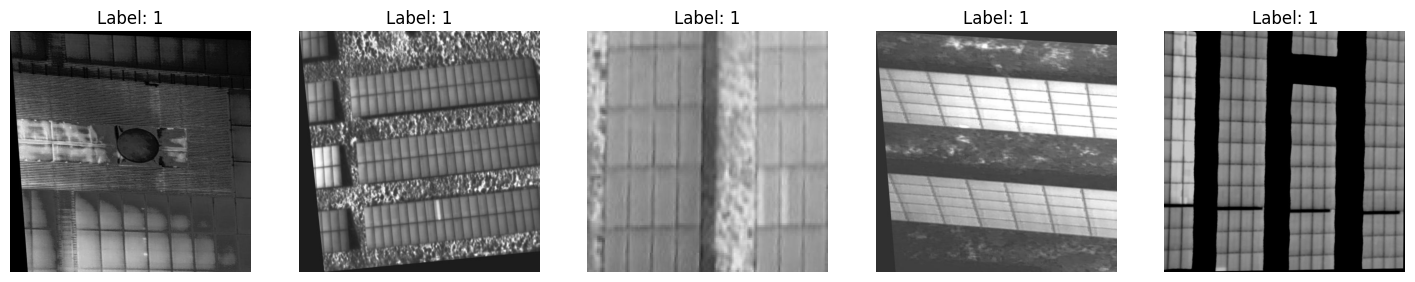

In [7]:
def show_samples(df, n=5):
    samples = df.sample(n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(18,5))

    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            img = Image.open(row["image_path"]).convert("RGB")
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {row['label']}")
            axes[i].axis("off")
        except Exception as e:
            axes[i].set_title(f"Error loading image:\n{e}", color='red')
            axes[i].axis("off")

    plt.show()

show_samples(df_train, n=5)


Image Transforms

In [8]:
# Standard input size for ResNet
image_size = 256

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


Custom Dataset Class

In [9]:
class PVPanelDataset(Dataset):
    """Dataset that loads images from a dataframe of file paths."""

    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        try:
            img = Image.open(row["image_path"]).convert("RGB")
        except:
            return None  # corrupt image fallback

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(row["label"], dtype=torch.long)
        return img, label


Custom Collate Function

In [10]:
def collate_remove_none(batch):
    """
    Removes None samples from batch (corrupt images).
    Returns None if batch becomes empty.
    """
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


DataLoader Setup

In [11]:
batch_size = 32
num_workers = 2   # adjust to 1 if Colab crashes

train_loader = DataLoader(
    PVPanelDataset(df_train, train_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_remove_none
)

val_loader = DataLoader(
    PVPanelDataset(df_val, test_transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_remove_none
)

test_loader = DataLoader(
    PVPanelDataset(df_test, test_transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_remove_none
)

print("Dataloaders ready.")


Dataloaders ready.


### Baseline CNN Model

In [12]:
# baseline CNN model with four convolutional layers
# max pooling after each pair
# dropout for regularization
# and two fully connected layers for classification
class BaselineCNN(nn.Module):

    # function to initialize all convolutional, pooling, dropout,
    # and fully connected layers
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()

        # first convolution block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # second convolution block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # regularization
        self.dropout = nn.Dropout(0.3)

        # fully connected layers
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    # function to define forward pass
    def forward(self, x):

        # conv blocks
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # flatten feature maps
        x = x.view(x.size(0), -1)

        # fully connected classifier
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)

        return x


In [13]:
# running this to ensure we are running GPU for training
# as runtime can be long
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize the baseline model, and move it to the selected device (GPU)
baseline_model = BaselineCNN(num_classes=2).to(device)
print(baseline_model) # print model architecture


BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


 ### Training and Validation

In [14]:


# function to train our model
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=0.001,
    class_weights=None
):

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # track loss and accuracy across epich
    history = {"train_loss": [],
               "val_loss": [],
               "train_acc": [],
               "val_acc": []
              }

    # iterate trhough epochs for training
    for epoch in range(num_epochs):
        model.train() # set the model to training mode
        running_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        # our training loop
        for images, labels in loop:

            # move input images and labels to our device (GPU)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # reset gradients
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels)
            loss.backward() # backdrop
            optimizer.step() # update weights

            # accumulate total loss for the epoch
            running_loss += loss.item() * images.size(0)

            # compute our training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # validation loop
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        # no gradient updates during validation,
        # disables backdrop to speed up inference
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # compute average validation loss and overall validation accuracy
        val_loss /= val_total
        val_acc = val_correct / val_total

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history


In [15]:
# count class occurrences
counts = df_full["label"].value_counts()

# minority and majority class sizes
minority = counts.get(0, 1)
majority = counts.get(1, 1)

# weight = inverse frequency
weight_for_0 = majority / minority
weight_for_1 = 1.0

# create class weight tensor for imbalance data
# and move it to training device
class_weights = torch.tensor(
    [weight_for_0, weight_for_1],
    dtype=torch.float).to(device
)

print("Class weights:", class_weights)


Class weights: tensor([71.1845,  1.0000], device='cuda:0')


In [16]:
# train our model
history_baseline = train_model(
    baseline_model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=0.0005,
    class_weights=class_weights
)


Epoch 1/10: 100%|██████████| 186/186 [16:24<00:00,  5.29s/it]


Epoch 1 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 2/10: 100%|██████████| 186/186 [01:14<00:00,  2.49it/s]


Epoch 2 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 3/10: 100%|██████████| 186/186 [01:12<00:00,  2.55it/s]


Epoch 3 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 4/10: 100%|██████████| 186/186 [01:12<00:00,  2.55it/s]


Epoch 4 | Train Acc: 0.9571 | Val Acc: 0.9865


Epoch 5/10: 100%|██████████| 186/186 [01:13<00:00,  2.53it/s]


Epoch 5 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 6/10: 100%|██████████| 186/186 [01:15<00:00,  2.47it/s]


Epoch 6 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 7/10: 100%|██████████| 186/186 [01:30<00:00,  2.06it/s]


Epoch 7 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 8/10: 100%|██████████| 186/186 [01:29<00:00,  2.08it/s]


Epoch 8 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 9/10: 100%|██████████| 186/186 [01:30<00:00,  2.07it/s]


Epoch 9 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 10/10: 100%|██████████| 186/186 [01:18<00:00,  2.38it/s]


Epoch 10 | Train Acc: 0.9862 | Val Acc: 0.9865


In [17]:
# this function is to run the model in evaluation mode
# and collect all predicitions that are true labels
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, labels in loader:
            images = images.to(device) # move batch to device
            outputs = model(images) # forward pass
            _, preds = outputs.max(1) # get predicted class indices

            # convert tensors to numpy arrays (required for metrics)
            # and store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


In [18]:
# get all true labels and model predictions from the test set
y_true, y_pred = get_predictions(baseline_model, test_loader)

# generate/print precision, recall, F1 scores for each class
print("Classification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=["Healthy", "Defect"])
)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm # call to display CM


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        11
      Defect       0.99      1.00      0.99       733

    accuracy                           0.99       744
   macro avg       0.49      0.50      0.50       744
weighted avg       0.97      0.99      0.98       744



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[  0,  11],
       [  0, 733]])

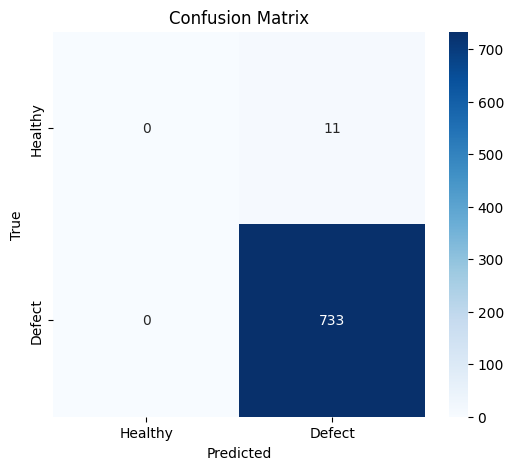

In [19]:
# plot our confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Defect"],
            yticklabels=["Healthy", "Defect"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [21]:
# this function will display the sample images the model misclassified
def show_incorrect_predictions(model, loader, num_images=6):
    model.eval()
    incorrect = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, labels in loader:
            images = images.to(device) # move images to device
            outputs = model(images) # forward pass
            _, preds = outputs.max(1) # get predicted class indices

            # collect misclassified samples until desired number is reached
            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    incorrect.append((img.cpu(),
                                      pred.cpu().item(),
                                      label.item())
                    )
                if len(incorrect) == num_images:
                    break
            if len(incorrect) == num_images:
                break

    # display the sample images
    fig, axes = plt.subplots(1, num_images, figsize=(18, 4))
    for i, (img, pred, label) in enumerate(incorrect):
        img_disp = img.permute(1, 2, 0).numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max())
        axes[i].imshow(img_disp)
        axes[i].set_title(f"Pred: {pred}, True: {label}", color="red")
        axes[i].axis("off")

    plt.show()


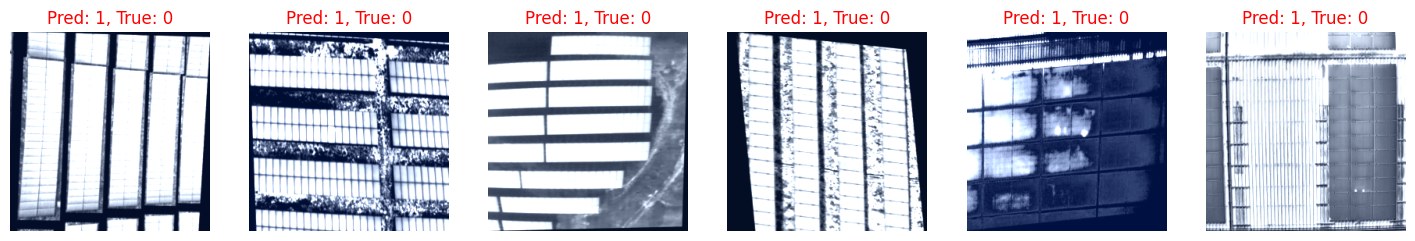

In [22]:
show_incorrect_predictions(baseline_model, test_loader)


In [23]:
# this function will display the sample images the model classified correctly
def show_correct_predictions(model, loader, num_images=6):
    model.eval()
    correct = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, labels in loader:
            images = images.to(device) # move batch to device
            outputs = model(images) # forward pass
            _, preds = outputs.max(1) # get predicted class indices

            # this loop will collect the correctly classified samples
            # until desired count is reached
            for img, pred, label in zip(images, preds, labels):
                if pred == label:
                    correct.append((img.cpu(),
                                    pred.cpu().item(),
                                    label.item())
                    )
                if len(correct) == num_images:
                    break
            if len(correct) == num_images:
                break

    # display correclty classified samples
    fig, axes = plt.subplots(1, num_images, figsize=(18, 4))
    for i, (img, pred, label) in enumerate(correct):
        img_disp = img.permute(1, 2, 0).numpy()
        img_disp = (img_disp - img_disp.min()) / img_disp.max()
        axes[i].imshow(img_disp)
        axes[i].set_title(f"Correct: {label}")
        axes[i].axis("off")

    plt.show()


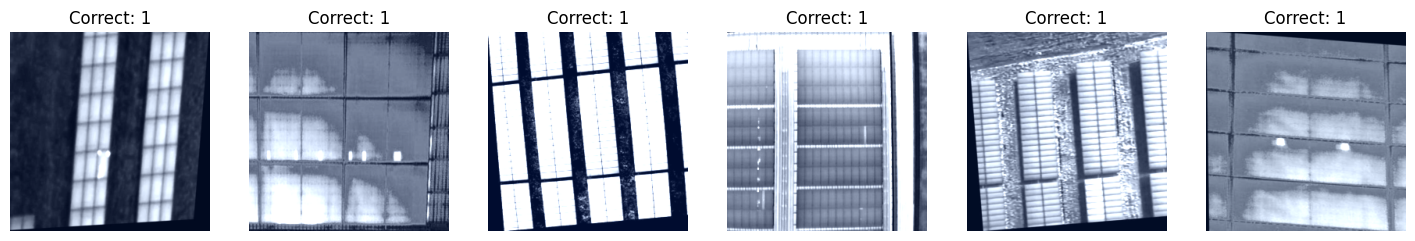

In [24]:
show_correct_predictions(baseline_model, test_loader)


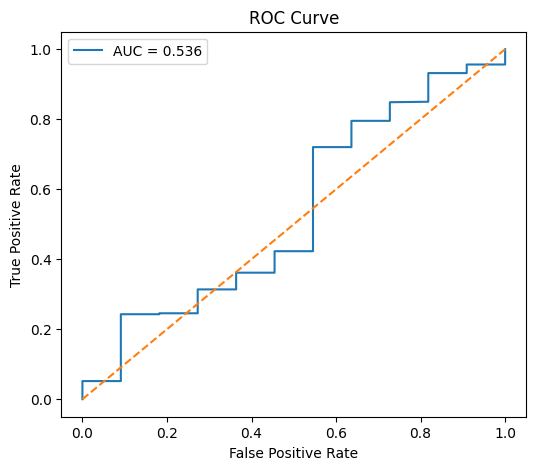

In [25]:
# function to plot ROC curve
def plot_roc(model, loader):
    model.eval()
    probs = []
    labels = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, lbls in loader:
            images = images.to(device) # move to device
            outputs = model(images) # forward pass

            # compute softmax probabilities
            softmax = torch.softmax(outputs, dim=1)
            probs.extend(softmax[:,1].cpu().numpy())  # probability of class 1
            labels.extend(lbls.numpy())

    # compute ROC curve points and area under the curve
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    # plot our ROC curve
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

plot_roc(baseline_model, test_loader)


ResNet18 Initialization

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_resnet18(num_classes=2, freeze=True):
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)

    if freeze:
        for p in model.parameters():
            p.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

model = initialize_resnet18()
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Class Weight Calculation